In [1]:
import dataloader
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [2]:
seed = 3
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

1.8.0
cuda


In [4]:
def read_bci_data():
    S4b_train = np.load('S4b_train.npz')
    X11b_train = np.load('X11b_train.npz')
    S4b_test = np.load('S4b_test.npz')
    X11b_test = np.load('X11b_test.npz')

    train_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
    train_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
    test_data = np.concatenate((S4b_test['signal'],  X11b_test['signal']), axis=0)
    test_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)

    train_label = train_label - 1
    test_label = test_label -1
    train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
    test_data = np.transpose(np.expand_dims(test_data, axis=1), (0, 1, 3, 2))

    mask = np.where(np.isnan(train_data))
    train_data[mask] = np.nanmean(train_data)

    mask = np.where(np.isnan(test_data))
    test_data[mask] = np.nanmean(test_data)

    print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

    return train_data, train_label, test_data, test_label

In [5]:
train_data, train_label, test_data, test_label = read_bci_data()

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


# DataLoader

In [6]:
dataset = TensorDataset(torch.from_numpy(train_data),torch.from_numpy(train_label))
loader_train = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=4)

dataset = TensorDataset(torch.from_numpy(test_data),torch.from_numpy(test_label))
loader_test = DataLoader(dataset, batch_size=256, shuffle=False, num_workers=4)

# EEG

In [7]:
class EEGNet(nn.Module):
    def __init__(self, activation):
        super(EEGNet, self).__init__()
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25), bias=False),
            nn.BatchNorm2d(16, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=16, bias=False),
            nn.BatchNorm2d(32, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
            activation,
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4), padding=0),
            nn.Dropout(p=0.25)
        )
        self.seperableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7), bias=False),
            nn.BatchNorm2d(32, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
            activation,
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8), padding=0),
            nn.Dropout(p=0.25)
        )
        self.classify = nn.Linear(736, 2)
        
    def forward(self, x):
        out = self.firstconv(x)
        out = self.depthwiseConv(out)
        out = self.seperableConv(out)
        out = out.view(out.shape[0], -1)
        out = self.classify(out)
        
        return out

# DeepConv

In [8]:
class DeepConvNet(nn.Module):
    def __init__(self, activation):
        super(DeepConvNet, self).__init__()
        self.conv0 = nn.Conv2d(1, 25, kernel_size=(1,5))
        channels = [25,25,50,100,200]
        kernel_sizes = [None, (2,1), (1,5), (1,5), (1,5)]
        for i in range(1, len(channels)):
            setattr(self, 'conv'+str(i), nn.Sequential(
                nn.Conv2d(channels[i-1], channels[i], kernel_size=kernel_sizes[i]),
                nn.BatchNorm2d(channels[i], eps=1e-5, momentum=0.1),
                activation,
                nn.MaxPool2d(kernel_size=(1,2)),
                nn.Dropout(p=0.5)
            ))
        self.classify = nn.Linear(8600, 2)
        
    def forward(self, x):
        out = self.conv0(x)
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = out.view(out.shape[0], -1)
        neurons = out.shape[0]
        out = self.classify(out)
        
        return out

In [9]:
lr = 0.001
epochs = 300

# Different activation function

In [10]:
def train_activation(loader_train, loader_test, activations, net):
    Loss = nn.CrossEntropyLoss()
    df = pd.DataFrame()
    df['epoch'] = range(1, epochs+1)
    best_wts = {'ReLU':None, 'LeakyReLU':None, 'ELU':None}
    best_acc = {'ReLU':0, 'LeakyReLU':0, 'ELU':0}
    for name, activation in activations.items():
        if net == 'EEG':
            model = EEGNet(activation)
        elif net == 'DeepConv':
            model = DeepConvNet(activation)
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
        acc_train = list()
        acc_test = list()
        print(f'----- activation function : {name:s} -----')
        for epoch in range(1, epochs+1):
            # train
            model.train()
            loss_train = 0
            acc = 0
            for idx, (data, label) in enumerate(loader_train):
                data = data.to(device, dtype=torch.float)
                label = label.to(device, dtype=torch.long)
                predict = model(data)
                loss = Loss(predict, label)
                loss_train += loss.item()
                acc += predict.max(dim=1)[1].eq(label).sum().item()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            loss_train /= len(loader_train.dataset)
            acc = 100.*acc / len(loader_train.dataset)
            if epoch%10 == 0:
                print(f'epcoh{epoch:>3d}  loss:{loss_train:.4f}  acc:{acc:.1f}%')
            acc_train.append(acc)
            # test
            model.eval()
            acc = evaluate(model, loader_test)
            acc_test.append(acc)
            # update best_wts
            if acc > best_acc[name]:
                best_acc[name] = acc
                best_wts[name] = copy.deepcopy(model.state_dict())
        df[name+'_train'] = acc_train
        df[name+'_test'] = acc_test

    return df, best_wts

# Different net

In [11]:
def train_net(loader_train, loader_test, net):
    activations = {'ReLU':nn.ReLU(), 'LeakyReLU':nn.LeakyReLU(), 'ELU':nn.ELU()}
    df, best_wts = train_activation(loader_train, loader_test, activations, net)
    
    for name, wts in best_wts.items():
        torch.save(wts, os.path.join(net+' models', name+'.pt'))
    
    figure = plot(df)    
    print('\n')
    for column in df.columns[1:]:
        print(f'{column} max acc: {df[column].max():.1f}%')

# Evaluate accuarcy

In [12]:
def evaluate(model, loader_test):
    model.eval()
    acc = 0
    for idx, (data, label) in enumerate(loader_test):
        data = data.to(device, dtype=torch.float)
        label = label.to(device, dtype=torch.long)
        predict = model(data)
        acc += predict.max(dim=1)[1].eq(label).sum().item()
    
    acc = 100.*acc / len(loader_test.dataset)
    
    return acc

# Plot accuarcy

In [13]:
def plot(dataframe):
    fig = plt.figure(figsize=(10,6))
    for name in dataframe.columns[1:]:
        plt.plot('epoch', name, data=dataframe)
    plt.title('Activation function comparision')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy(%)')
    plt.legend()
    
    return fig

# EEG

----- activation function : ReLU -----
epcoh 10  loss:0.0021  acc:75.7%
epcoh 20  loss:0.0019  acc:81.7%
epcoh 30  loss:0.0016  acc:85.6%
epcoh 40  loss:0.0014  acc:88.6%
epcoh 50  loss:0.0011  acc:90.6%
epcoh 60  loss:0.0011  acc:91.1%
epcoh 70  loss:0.0010  acc:92.4%
epcoh 80  loss:0.0009  acc:93.0%
epcoh 90  loss:0.0008  acc:94.4%
epcoh100  loss:0.0007  acc:95.1%
epcoh110  loss:0.0007  acc:93.8%
epcoh120  loss:0.0007  acc:95.2%
epcoh130  loss:0.0006  acc:95.7%
epcoh140  loss:0.0006  acc:95.2%
epcoh150  loss:0.0006  acc:95.1%
epcoh160  loss:0.0008  acc:95.1%
epcoh170  loss:0.0005  acc:95.6%
epcoh180  loss:0.0006  acc:96.3%
epcoh190  loss:0.0006  acc:96.4%
epcoh200  loss:0.0005  acc:97.5%
epcoh210  loss:0.0005  acc:96.2%
epcoh220  loss:0.0004  acc:97.4%
epcoh230  loss:0.0005  acc:97.0%
epcoh240  loss:0.0004  acc:97.6%
epcoh250  loss:0.0005  acc:97.6%
epcoh260  loss:0.0004  acc:97.8%
epcoh270  loss:0.0005  acc:97.4%
epcoh280  loss:0.0004  acc:97.3%
epcoh290  loss:0.0005  acc:97.2%
epco

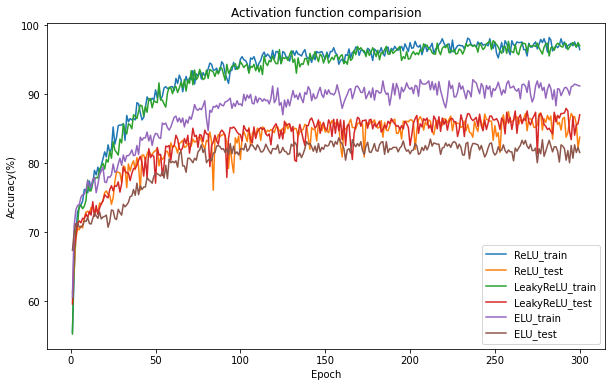

In [14]:
train_net(loader_train, loader_test, 'EEG')

# DeepConv

----- activation function : ReLU -----
epcoh 10  loss:0.0025  acc:71.7%
epcoh 20  loss:0.0023  acc:74.9%
epcoh 30  loss:0.0020  acc:79.0%
epcoh 40  loss:0.0018  acc:80.7%
epcoh 50  loss:0.0020  acc:80.4%
epcoh 60  loss:0.0018  acc:80.7%
epcoh 70  loss:0.0017  acc:83.1%
epcoh 80  loss:0.0016  acc:85.5%
epcoh 90  loss:0.0015  acc:85.0%
epcoh100  loss:0.0014  acc:85.9%
epcoh110  loss:0.0013  acc:86.8%
epcoh120  loss:0.0013  acc:87.2%
epcoh130  loss:0.0013  acc:88.4%
epcoh140  loss:0.0012  acc:88.7%
epcoh150  loss:0.0012  acc:90.2%
epcoh160  loss:0.0012  acc:90.8%
epcoh170  loss:0.0011  acc:90.7%
epcoh180  loss:0.0011  acc:90.2%
epcoh190  loss:0.0010  acc:92.3%
epcoh200  loss:0.0010  acc:89.4%
epcoh210  loss:0.0009  acc:92.3%
epcoh220  loss:0.0009  acc:92.8%
epcoh230  loss:0.0010  acc:92.0%
epcoh240  loss:0.0010  acc:89.9%
epcoh250  loss:0.0008  acc:93.5%
epcoh260  loss:0.0008  acc:93.0%
epcoh270  loss:0.0009  acc:93.1%
epcoh280  loss:0.0008  acc:92.7%
epcoh290  loss:0.0007  acc:95.0%
epco

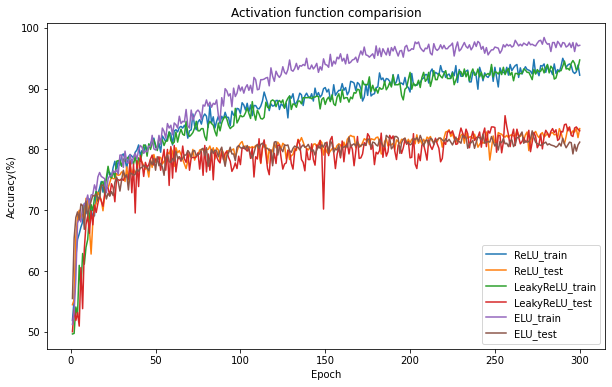

In [15]:
train_net(loader_train, loader_test, 'DeepConv')

# Show the highest accuarcy

In [16]:
model = EEGNet(nn.LeakyReLU())
model.load_state_dict(torch.load(os.path.join('EEG models','LeakyReLU.pt')))
model.to(device)

EEGNet(
  (firstconv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (depthwiseConv): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (seperableConv): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (classify): Linear(in_features=736, out_features=2, bias=True)
)

In [17]:
acc = evaluate(model, loader_test)
print(f'accuracy: {acc:.1f}%')

accuracy: 88.0%
